## An individual-based network model to evaluate interventions for controlling pneumococcal transmission

Author:
- Gerry Tonkin-Hill @gtonkinhill
- Alex Zarebski @aezarebski

Date: 2018-10-01

## Summary

[Karlsson et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2442080/) developed a contact network model to evaluate the efficacy of interventions aiming to control pneumococcal transmission. They used demographic data from Sweden during the mid-2000s to estimate model parameters.

In their model individuals are assigned several features: an age, a household, and potentially a class in school/day care. These features then influence the rate of transmission between individuals in the population. Together this defines a stochastic process of the number of people infected. We carry out a simulation of this process and then generate some visualisations of this.

## Model and implementation

Initially we need to set the parameters of the model. These are taken from the paper and estimated using Swedish demographic data.

In [1]:
library(ggplot2)
library(data.table)

In [2]:
#transmission rates
transmission.households <- 0.07
transmission.DCCs <- 0.04
transmission.school.classes <- 0.03
transmission.other.contacts <- 0.04

#age bias
age.bias.1 <- 1
age.bias.1to6 <- 0.33
age.bias.7to65 <- 0.18
age.bias.65 <- 0.3

prop.children.attending.DCCs <- 0.79
average.group.size.DCC <- 16.7
average.class.size.school <- 22
probability.of.other.contacts <- 0.5

pop.size <- 5000
n.initial.carriers <- 125
stop.time <- 156

#sweden population pyramid
sweden.pop.props <- c(2.9,2.9,2.7,2.4,3.4,3.4,3.1,3,3.1,3.5,3.1,2.9,2.7,3.2,2.6,1.9,1.4,1,0.6,0.1,0)
names(sweden.pop.props) <- c(seq(0,100,5)[-1], "100+")

#sweden family size proportions
num.siblings.props <- c(0.19,0.48,0.23,0.10)
names(num.siblings.props) <- c(0,1,2,3)
prop.single.parent <- 0.19


We now give the individuals in the simulation an age as well as assign them to schools, families and day care centres (DCC's) where appropriate.

In [3]:
pop.ages <- as.numeric(sample(names(sweden.pop.props), pop.size, replace = TRUE, prob = sweden.pop.props))
family.membership <- rep(NA, pop.size)
school.membership <- rep(NA, pop.size)
dcc.membership <- rep(NA, pop.size)
other.close.contact.pair <- rep(NA, pop.size)

#randomly assign an individual a close contact with probability 0.5.
npairs <- rbinom(1, pop.size, 0.5)
pairs <- matrix(sample(pop.size, 2*npairs, replace = TRUE), ncol=2)

#assign families
fam.id <- 1
while(sum(is.na(family.membership[pop.ages<=20]))>0){ #we still have un-assigned children
  n.children <- sample(as.numeric(names(num.siblings.props)), 1, prob=num.siblings.props) + 1
  child.index <- which((pop.ages<=20) & is.na(family.membership))[1:n.children]
  n.parents <- sample(c(1,2), 1, prob = c(prop.single.parent, 1-prop.single.parent))
  parent.index <- which((pop.ages>20) & (pop.ages<=50) & is.na(family.membership))[1:n.parents]
  family.membership[c(child.index, parent.index)] <- fam.id
  fam.id <- fam.id + 1
}

#assign dcc
dcc.id <- 1
n.under.5 <- sum(pop.ages<=5)
indexs.in.dcc <- sample(which(pop.ages<=5), size = floor(prop.children.attending.DCCs*n.under.5))
family.ids <-  unique(family.membership[indexs.in.dcc])
dcc.size <- 0
for(f in family.ids){
  index <- indexs.in.dcc[family.membership[indexs.in.dcc]==f]
  dcc.membership[index] <- dcc.id
  dcc.size <- dcc.size + length(index)
  if(dcc.size>average.group.size.DCC){
    dcc.size <- 0
    dcc.id <- dcc.id + 1
  }
}

#assign schools
#5 to 10
class.id <- 1
indexes.in.school <- which((pop.ages>5) & (pop.ages<=10))
family.ids <-  unique(family.membership[indexes.in.school])
class.size <- 0
for(f in family.ids){
  index <- indexes.in.school[family.membership[indexes.in.school]==f]
  school.membership[index] <- class.id
  class.size <- class.size + length(index)
  if(class.size>average.class.size.school){
    class.size <- 0
    class.id <- class.id + 1
  }
}

#10 to 15yrs
indexes.in.school <- which((pop.ages>10) & (pop.ages<=15))
family.ids <-  unique(family.membership[indexes.in.school])
class.size <- 0
for(f in family.ids){
  index <- indexes.in.school[family.membership[indexes.in.school]==f]
  school.membership[index] <- class.id
  class.size <- class.size + length(index)
  if(class.size>average.class.size.school){
    class.size <- 0
    class.id <- class.id + 1
  }
}

After we've assigned individuals to groups we need to set the rate of transmission between people.

In [4]:
transition.matrix <- matrix(1, nrow = pop.size, ncol = pop.size)
#household transmission
for(f in unique(family.membership[!is.na(family.membership)])){
  index <- which(family.membership==f)
  transition.matrix[t(combn(index, 2))] <- transition.matrix[t(combn(index, 2))] * (
    1 - transmission.households)
}

#dcc transmission
for(f in unique(dcc.membership[!is.na(dcc.membership)])){
  index <- which(dcc.membership==f)
  transition.matrix[t(combn(index, 2))] <- transition.matrix[t(combn(index, 2))] * (
    1 - transmission.DCCs)
}

#school transmission
for(f in unique(school.membership[!is.na(school.membership)])){
  index <- which(school.membership==f)
  transition.matrix[t(combn(index, 2))] <- transition.matrix[t(combn(index, 2))] * (
    1 - transmission.school.classes)
}

#other transmission
transition.matrix[pairs] <- transition.matrix[pairs] * (1 - transmission.other.contacts)
transition.matrix[pairs[,c(2,1)]] <- transition.matrix[pairs[,c(2,1)]] * (1 - transmission.other.contacts)

#bias probability vector
bias.probs <- rep(NA, pop.size)
bias.probs[pop.ages<=5] <- 0.33
bias.probs[pop.ages>65] <- 0.3
bias.probs[is.na(bias.probs)] <- 0.18

Now lets simulate! We assume a slightly simpler carriage duration of Poisson with mean 4 weeks.

In [5]:
status.vector <- rep(0, pop.size)
remaining.carriage <- rep(0, pop.size)

#initialise infections
index <- sample(pop.size, n.initial.carriers)
status.vector[index] <- 1
remaining.carriage[index] <- rpois(n = n.initial.carriers, lambda = 4)

pop.ages.factor <- factor(pop.ages)
n.infected.vector <- rep(NA, stop.time)
n.infected.age.matrix <- matrix(NA, nrow = stop.time, ncol = length(unique(pop.ages.factor)))
colnames(n.infected.age.matrix) <- levels(pop.ages.factor)

for(t in 1:stop.time){
  # message(paste("Time:", t))
  
  prob.infection <- 1-exp(rowSums(log((1-status.vector) * transition.matrix)))
  prob.infection <- prob.infection*bias.probs
  is.infected <- runif(pop.size)<prob.infection
  
  n.new.infections <- sum((status.vector<=0) & is.infected)
  remaining.carriage[(status.vector<=0) & is.infected] <- rpois(n = n.new.infections, lambda = 4) + 1
  status.vector <- is.infected
  remaining.carriage <- remaining.carriage-1
  remaining.carriage[remaining.carriage<0] <- 0
  status.vector[remaining.carriage<=0] <- 0
  
  n.infected.vector[[t]] <- sum(status.vector)
  
  n.infected.age.matrix[t,] <- table(pop.ages.factor[status.vector==1])
  
}

We plot the number of people infected over time.

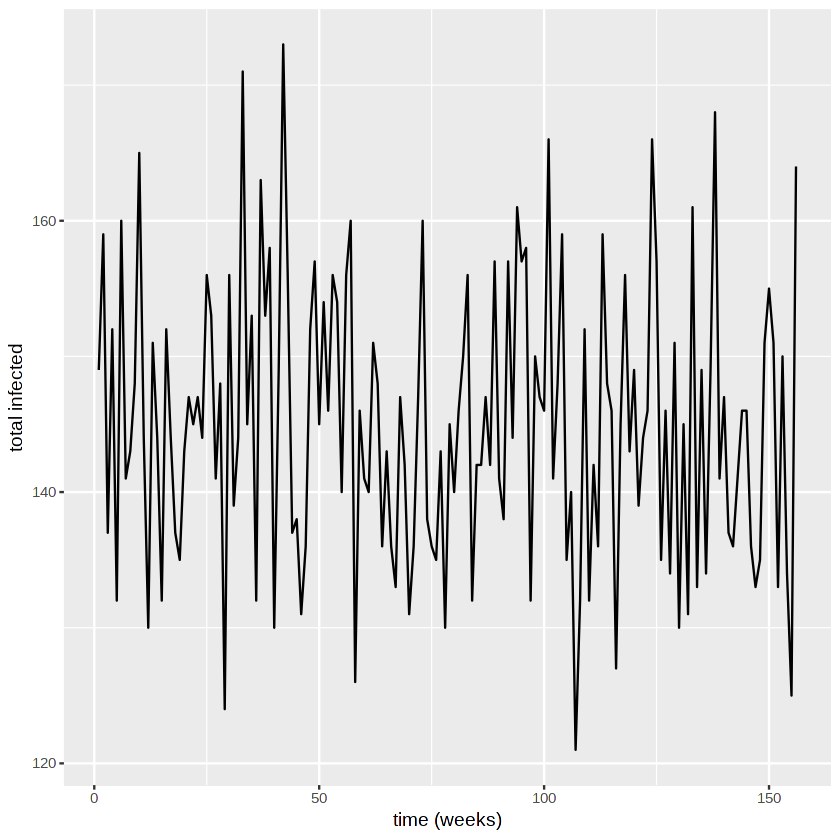

In [6]:
plot.df <- data.frame(time=1:stop.time, total.infected=n.infected.vector, 
                      stringsAsFactors = FALSE)

ggplot(plot.df, aes(x=time, y=total.infected)) +
  geom_line() + xlab("time (weeks)") + ylab("total infected")

We plot the incidence in different age groups.

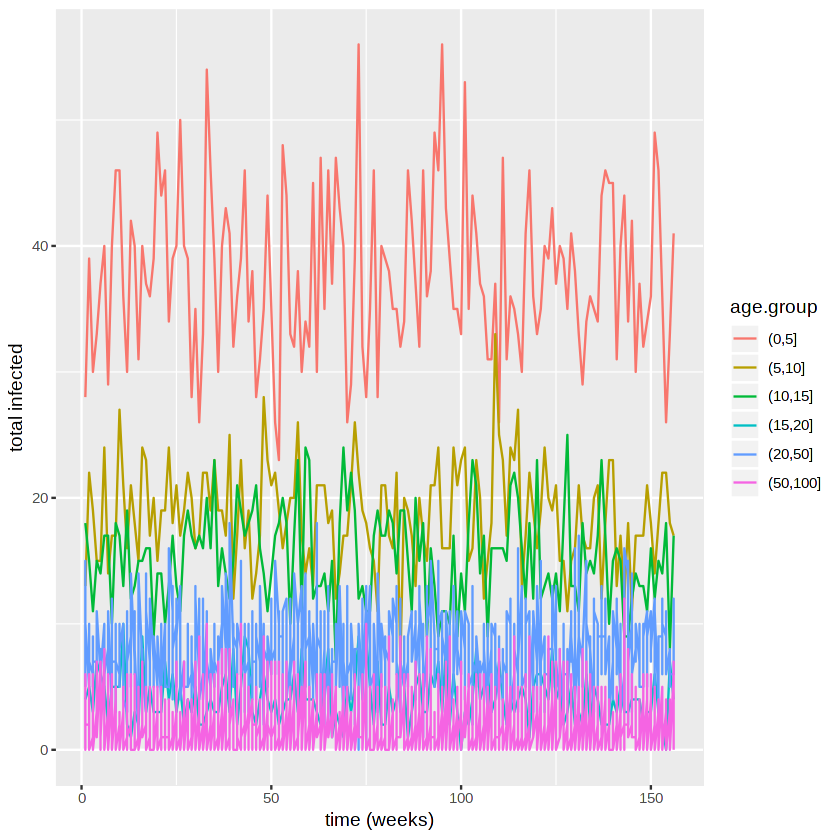

In [7]:
plot.df <- melt(n.infected.age.matrix)
colnames(plot.df) <- c("time", "age.group", "number infected")
plot.df$age.group <- cut(plot.df$age.group, breaks = c(0,5,10,15,20,50,100))

ggplot(plot.df, aes(x=time, y=`number infected`, col=age.group)) + 
  geom_line() + 
  xlab("time (weeks)") + ylab("total infected")

We can compare this to the number in each group.

In [8]:
table(cut(pop.ages, breaks = c(0,5,10,15,20,50,100)))


   (0,5]   (5,10]  (10,15]  (15,20]  (20,50] (50,100] 
     339      282      243      214     1970     1952 